# Spectral Clustering


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [1]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, plot_graph_matrix, plot_clustering_result, plot_edges_and_points
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import os
import scipy

## Generating the data

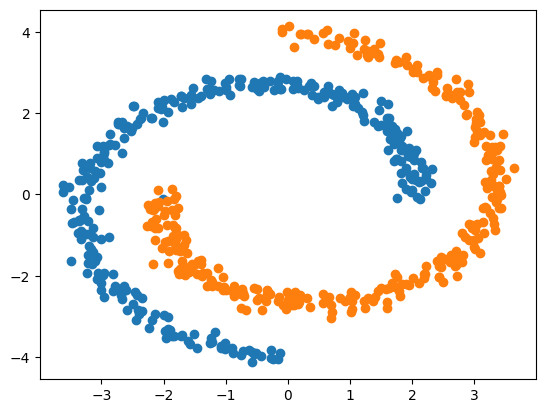

Signature: worst_case_blob(num_samples, delta=5)
Docstring:
Generates a single blob.

:param num_samples: number of samples to create in the blob
:param delta:
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment
File:      ~/Desktop/MVA/S2/Graphs in machine learning/Exercises/TP1/generate_data.py
Type:      function

In [2]:
# Example

for fn in [two_moons]:  # try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
# You can check the documentation of each function to see the optional parameters, e.g.:
worst_case_blob?

## Building similarity graph

In [3]:
def build_similarity_graph(X, var=1.0, eps=0.0, k=0):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """
  
    similarities = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            similarities[i, j] = np.exp(-np.linalg.norm(X[i] - X[j])**2 / (2*var))

    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        for i in range(n):
            for j in range(n):
                if i!=j and similarities[i, j] >= eps:
                    W[i, j] = similarities[i, j]

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the n-k remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        for i in range(n):
            neighbours = np.argsort(similarities[i])
            neighbours = neighbours[neighbours != i]
            neighbours = neighbours[-k:]
            for j in neighbours:
                W[i, j] = similarities[i, j]
                W[j, i] = similarities[i, j]

    return W

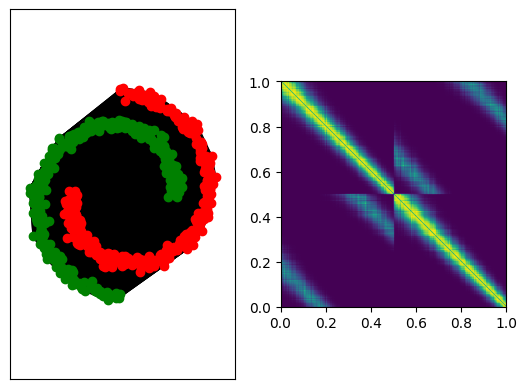

In [4]:
# Example

W = build_similarity_graph(X)
W[0, 599] = 1    # add two placeholder edges to reproduce example picture
W[10, 500] = 1   # 


plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

## Computing the Laplacian

In [5]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    L = np.zeros(W.shape)
    D = np.diag(np.sum(W, axis=1))

    if laplacian_normalization == 'unn':
        L = D - W
    
    elif laplacian_normalization == 'sym':
        D_sqrt = np.diag(1/np.sqrt(np.sum(W, axis=1)))
        L = np.eye(W.shape[0]) - D_sqrt @ W @ D_sqrt
    
    elif laplacian_normalization == 'rw':
        D_inv = np.diag(1/np.sum(W, axis=1))
        L = np.eye(W.shape[0]) - D_inv @ W
    
    return L

## Clustering

In [6]:
def spectral_clustering(L, chosen_eig_indices=None, num_classes=2):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    E, U = scipy.linalg.eigh(L)

    # Define tolerance
    tolerance = 1e-8
    
    idx = np.argsort(np.real(E))
    E = np.real(E[idx])
    U = np.real(U[:, idx])
    
    if chosen_eig_indices is None:
        if np.sum(np.abs(E) < tolerance) > 1:
            chosen_eig_indices = range(num_classes-1)
        else:
            chosen_eig_indices = range(1, num_classes)
    
    selected_evecs = U[:, chosen_eig_indices]
    row_norms = np.sqrt(np.sum(selected_evecs**2, axis=1))
    row_norms[row_norms == 0] = 1
    normalized_evecs = selected_evecs / row_norms[:, np.newaxis]
    
    kmeans = KMeans(n_clusters=num_classes, random_state=42)
    Y = kmeans.fit_predict(normalized_evecs)
    
    return Y

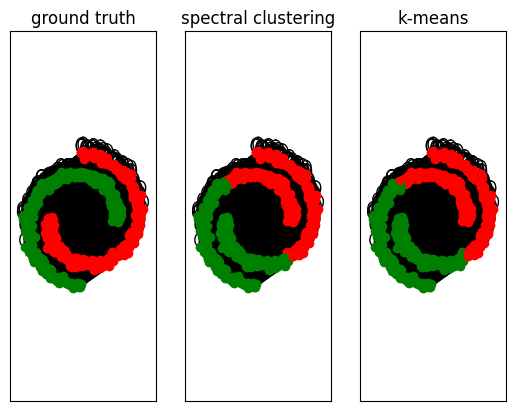

In [7]:
# Example

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1, 2], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes, random_state=42).fit_predict(X))

## Parameter sensitivity 

In [8]:
def parameter_sensitivity():
    """
    TO BE COMPLETED.

    A function to test spectral clustering sensitivity to parameter choice.
    """
    num_samples = 500
    num_classes = 2
    
    var_candidates = np.logspace(-2, 2, 10)
    k_candidates = np.arange(5, 51, 5)
    eps_candidates = np.linspace(0.1, 0.9, 10)
    laplacian_types = ['unn', 'sym', 'rw']
    
    results = {
        'var': {'params': var_candidates, 'scores': []},
        'k': {'params': k_candidates, 'scores': []},
        'eps': {'params': eps_candidates, 'scores': []},
        'laplacian': {'params': laplacian_types, 'scores': []}
    }
    
    X, Y = two_moons(num_samples, 1, 0.02)

    base_var = 1.0
    base_eps = 0.0
    base_k = 10
    base_laplacian = 'unn'
    
    print("Testing variance sensitivity...")
    for var in var_candidates:
        parameter_wrap = {'var': var, 'eps': base_eps, 'k': base_k}
        W = build_similarity_graph(X, **parameter_wrap)
        L = build_laplacian(W, base_laplacian)
        Y_rec = spectral_clustering(L, None, num_classes)
        score = skm.adjusted_rand_score(Y, Y_rec)
        results['var']['scores'].append(score)
    
    print("Testing k-NN sensitivity...")    
    for k in k_candidates:
        parameter_wrap = {'var': base_var, 'eps': base_eps, 'k': k}
        W = build_similarity_graph(X, **parameter_wrap)
        L = build_laplacian(W, base_laplacian)
        Y_rec = spectral_clustering(L, None, num_classes)
        score = skm.adjusted_rand_score(Y, Y_rec)
        results['k']['scores'].append(score)
    
    print("Testing epsilon sensitivity...")
    for eps in eps_candidates:
        parameter_wrap = {'var': base_var, 'eps': eps, 'k': 0}
        W = build_similarity_graph(X, **parameter_wrap)
        L = build_laplacian(W, base_laplacian)
        Y_rec = spectral_clustering(L, None, num_classes)
        score = skm.adjusted_rand_score(Y, Y_rec)
        results['eps']['scores'].append(score)
    
    print("Testing Laplacian normalization sensitivity...")
    for lap_type in laplacian_types:
        parameter_wrap = {'var': base_var, 'eps': base_eps, 'k': base_k}
        W = build_similarity_graph(X, **parameter_wrap)
        L = build_laplacian(W, lap_type)
        Y_rec = spectral_clustering(L, None, num_classes)
        score = skm.adjusted_rand_score(Y, Y_rec)
        results['laplacian']['scores'].append(score)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    ax1.semilogx(results['var']['params'], results['var']['scores'], 'b-o')
    ax1.set_xlabel('Variance (σ²)')
    ax1.set_ylabel('Adjusted Rand Index')
    ax1.set_title('Variance Sensitivity')
    ax1.grid(True)
    
    ax2.plot(results['k']['params'], results['k']['scores'], 'g-o')
    ax2.set_xlabel('Number of neighbors (k)')
    ax2.set_ylabel('Adjusted Rand Index')
    ax2.set_title('k-NN Sensitivity')
    ax2.grid(True)
    
    ax3.plot(results['eps']['params'], results['eps']['scores'], 'r-o')
    ax3.set_xlabel('Epsilon threshold')
    ax3.set_ylabel('Adjusted Rand Index')
    ax3.set_title('Epsilon Sensitivity')
    ax3.grid(True)
    
    ax4.bar(range(len(laplacian_types)), results['laplacian']['scores'])
    ax4.set_xticks(range(len(laplacian_types)))
    ax4.set_xticklabels(laplacian_types)
    ax4.set_ylabel('Adjusted Rand Index')
    ax4.set_title('Laplacian Normalization Sensitivity')
    
    plt.tight_layout()
    plt.show()
    
    return results

## Image segmentation

In [9]:
def image_segmentation(input_img='four_elements.bmp'):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    filename = os.path.join('data', input_img)
    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))
    im_side = np.size(X, 1)
    
    # Create coordinate grid
    y_coords, x_coords = np.mgrid[0:im_side, 0:im_side]
    
    # Normalize to [0,1]
    x_coords = x_coords / im_side
    y_coords = y_coords / im_side
    
    # Combine color and spatial features
    spatial_weight = 0.1
    Xr = np.column_stack([
        X.reshape(im_side**2, 3),
        spatial_weight * x_coords.reshape(im_side**2, 1),
        spatial_weight * y_coords.reshape(im_side**2, 1)
    ])
    
    var = 0.02
    k = 30
    laplacian_normalization = 'sym'
    num_classes = 5
    chosen_eig_indices = range(1, num_classes)
    
    print("Building similarity graph...")
    W = build_similarity_graph(Xr, var=var, k=k)

    print("Building Laplacian matrix...")
    L = build_laplacian(W, laplacian_normalization)

    print("Running spectral clustering...")
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(X)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec, cmap='tab20')
    plt.title(f'Segmented Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Building similarity graph...
Building Laplacian matrix...
Running spectral clustering...


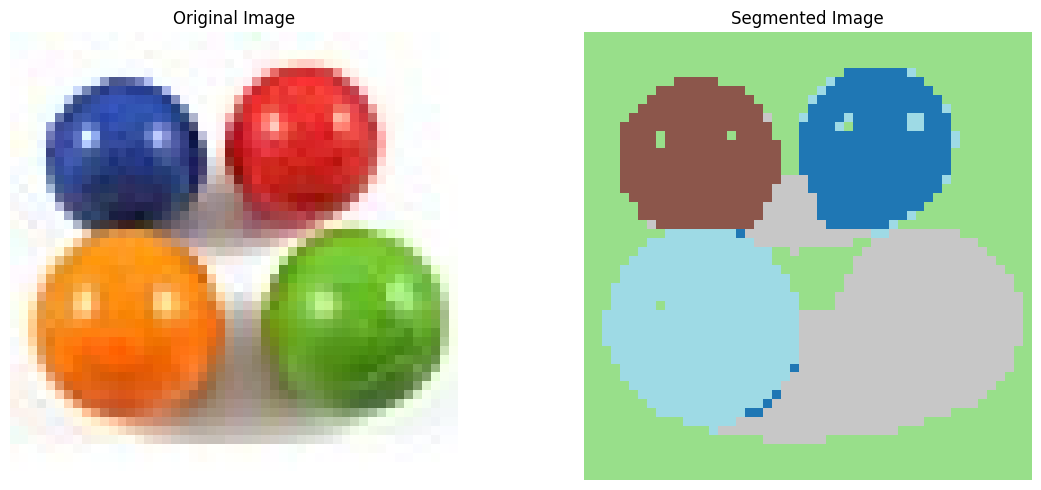

In [10]:
image_segmentation()

# Questions

### Q1.1: What is the purpose of the optional parameter in `worst_case_blob`?

The optional parameter `delta` of the implemented function `worst_case_blob` is used to deliberately place the last point of the blob at a specific distance from the rest of the data. In other words, this creates an outlier point that is `delta` units further out than the furthest point in the original blob. 

### Q1.2: While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

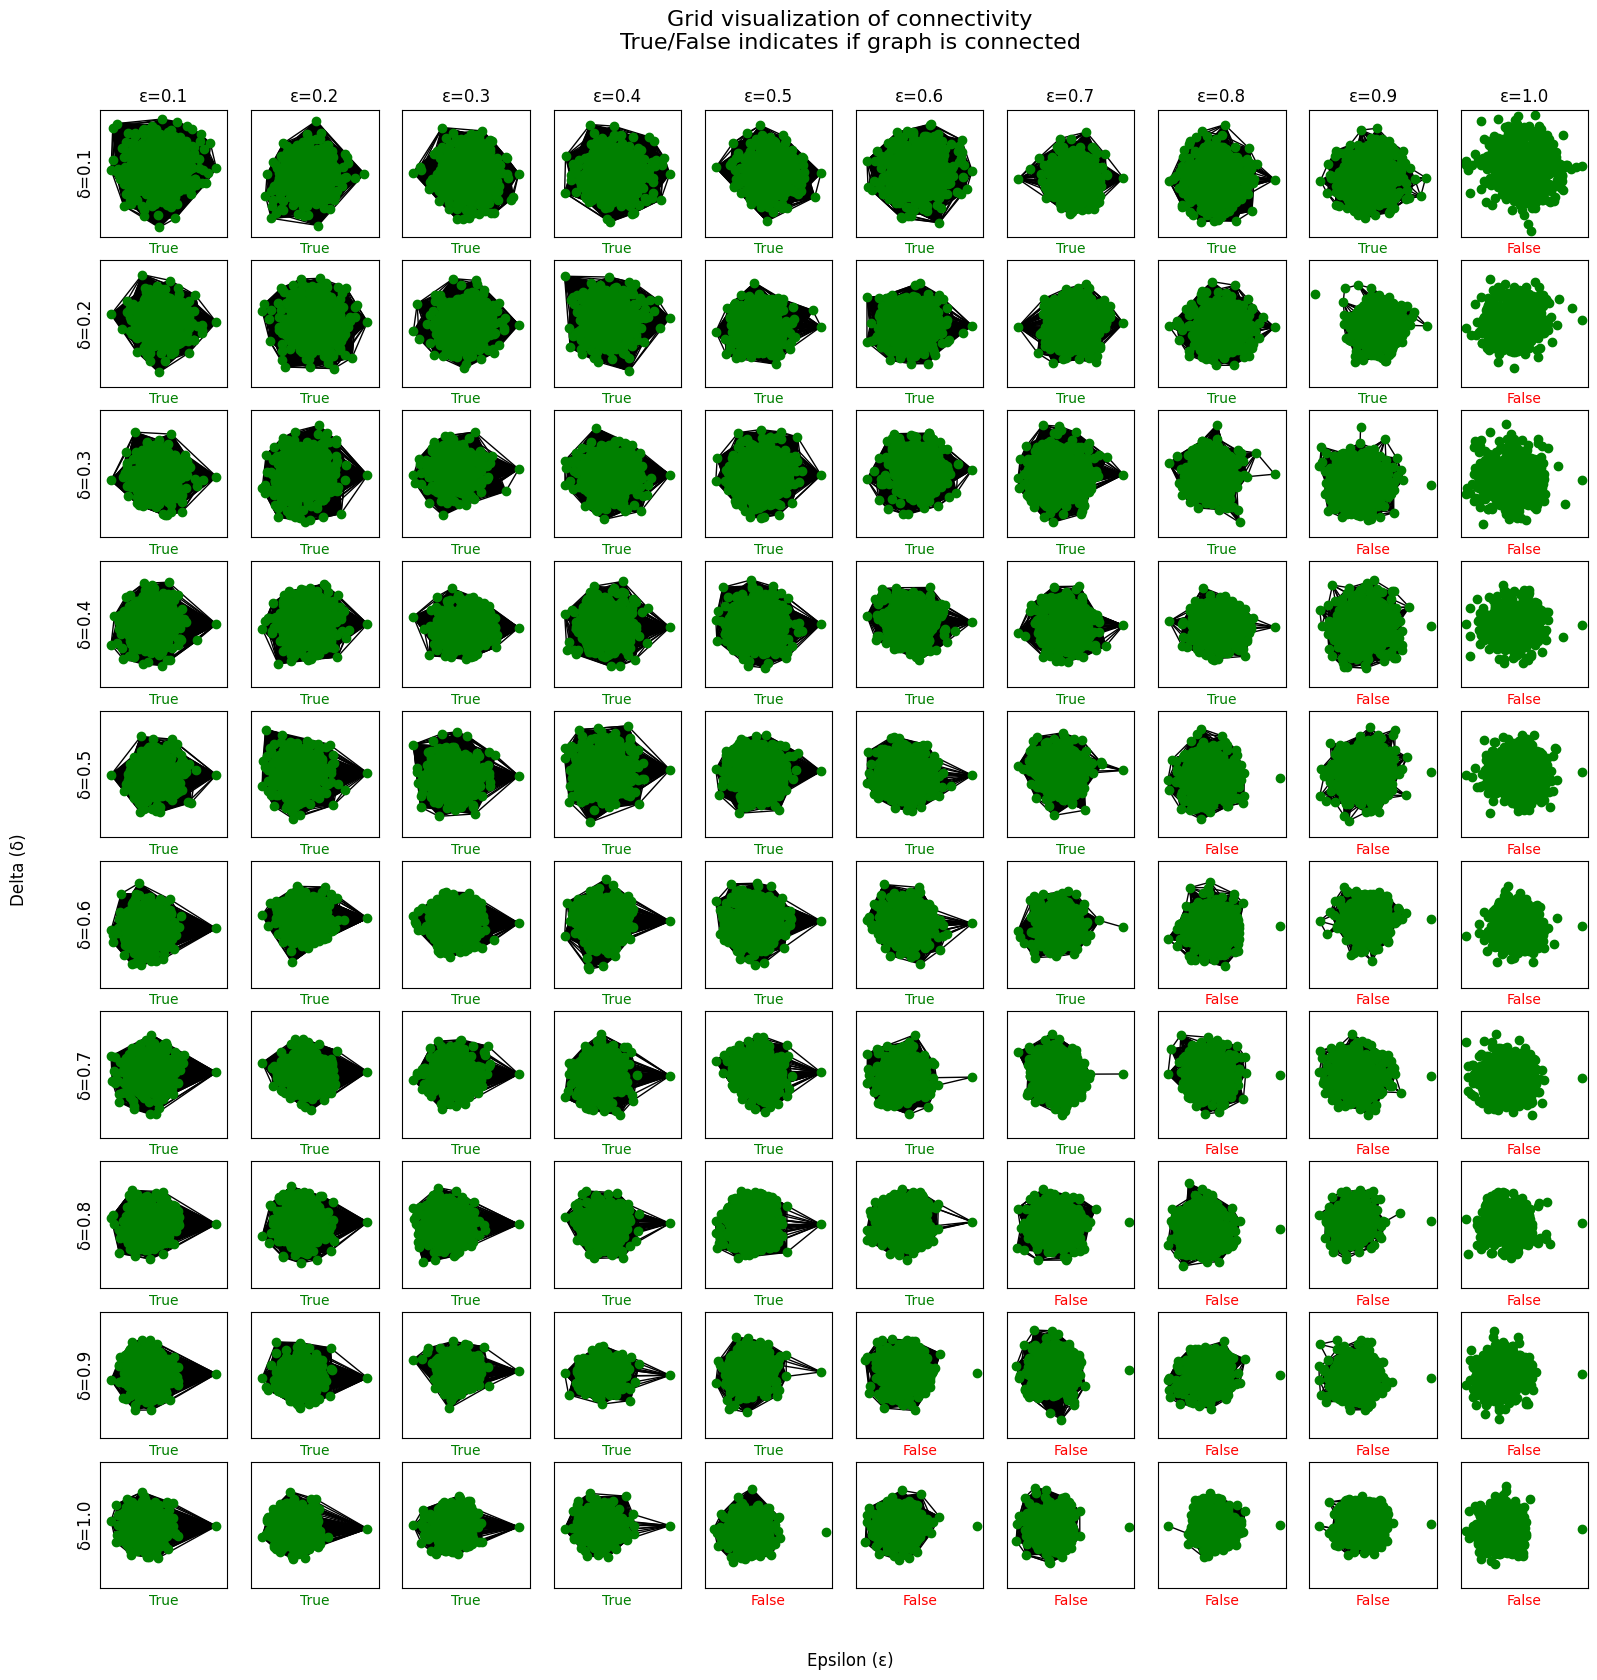

In [11]:
fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(11, 11, height_ratios=[1]*10 + [0.3], width_ratios=[1]*10 + [0.3])

delta_values = np.linspace(0.1, 1, 10)
eps_values = np.linspace(0.1, 1, 10)

axes = []
for i in range(10):
    axes_row = []
    for j in range(10):
        X, Y = worst_case_blob(num_samples=600, delta=delta_values[i])
        W = build_similarity_graph(X, eps=eps_values[j])
        
        ax = fig.add_subplot(gs[i, j])
        plot_edges_and_points(X, Y, W)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        is_connected = any(i > eps_values[j] for i in W[-1])
        plt.text(0.5, -0.1, str(is_connected), 
                transform=ax.transAxes, 
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=10,
                color='green' if is_connected else 'red')
        
        axes_row.append(ax)
    axes.append(axes_row)

for j, eps in enumerate(eps_values):
    axes[0][j].set_title(f'ε={eps:.1f}', fontsize=12)

for i, delta in enumerate(delta_values):
    axes[i][0].set_ylabel(f'δ={delta:.1f}', fontsize=12)

fig.supxlabel('Epsilon (ε)', fontsize=12, y=0.1)
fig.supylabel('Delta (δ)', fontsize=12, x=0.08)
fig.suptitle('Grid visualization of connectivity\nTrue/False indicates if graph is connected', 
             fontsize=16, y=0.93)

plt.show()

One can see that when increasing `delta`, it is necessary to decrease `epsilon` to preserve the connectivity of the similarity graph. This is however a bad idea in the context of clustering, especially when considering multiple different clusters, as low values of `epsilon` could lead to grouping data points which belong to distinct clusters. Furthermore, the resulting similarity graph shows long edges between points that don't necessarily reflect the natural structure of the data.

### Q1.3: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

In this setting, I would say that disregarding the connectivity constraint can be beneficial to the overall graph structure, since there is only a single outlier point out of the 600 samples. Not only would this decrease the chances of incorrect classification in the context of multiple families, it would also allow us to understand the intracluster structure. When comparing k-NN to ε-graphs, we find that k-NN offers certain advantages as far as building a connected graph is concerned. While ε-graphs rely on a fixed global distance threshold that may not adapt well to varying data densities (e.g. outliers), k-NN graphs ensure that each point maintains connections to a fixed number of neighbours, adapting to local data density. Therefore, choosing a large enough k could guarantee global connectivity, while providing a better understanding of the similarity graph structure.

### Q2.1: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

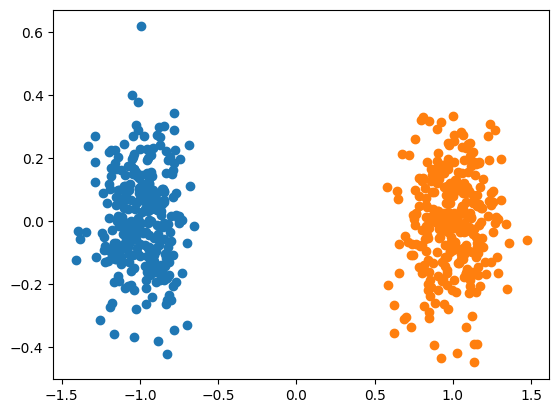

Signature: blobs(num_samples, n_blobs=2, blob_var=0.15, surplus=0)
Docstring:
Creates N gaussian blobs evenly spaced across a circle.

:param num_samples: number of samples to create in the dataset
:param n_blobs:      how many separate blobs to create
:param blob_var:    gaussian variance of each blob
:param surplus:     number of extra samples added to first blob to create unbalanced classes
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment
File:      ~/Desktop/MVA/S2/Graphs in machine learning/Exercises/TP1/generate_data.py
Type:      function

In [12]:
blobs?
X, Y = blobs(num_samples=600)
plot_clusters(X, Y)

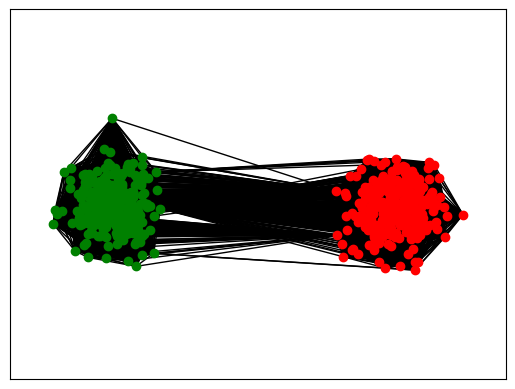

In [13]:
W = build_similarity_graph(X, k=300)
plot_edges_and_points(X, Y, W)

Based on the analysis in question 1, I decided to opt for a k-NN approach for building a connected similarity graph. Since both blobs are well-separated and equally populated (300 each), it suffices to take k=300 to ensure global connectivity of the graph.

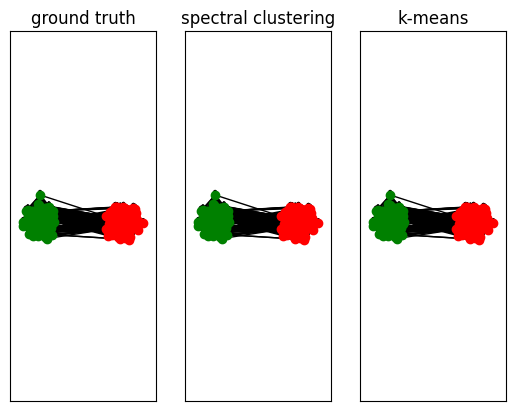

In [14]:
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=2)

plot_clustering_result(X, Y, L, Y_rec, KMeans(2, random_state=42).fit_predict(X))

As seen in class, the second smallest eigenvector of the Laplacian provides the optimal solution for partitioning the graph into two connected components in a way that minimizes the ratio cut, when considering the continuous relaxation. Furthermore, since we are in the case of a connected graph, we know that only the first eigenvector has an associated eigenvalue of value 0. After having computed the second smallest eigenvector, we can then perform our clustering by applying k-means with k=2 to the eigenvector to obtain the 2 clusters. When comparing this to the vanilla k-means, we can see that both perform equally well, both classifying all the data points correctly.

### Q2.2: Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.

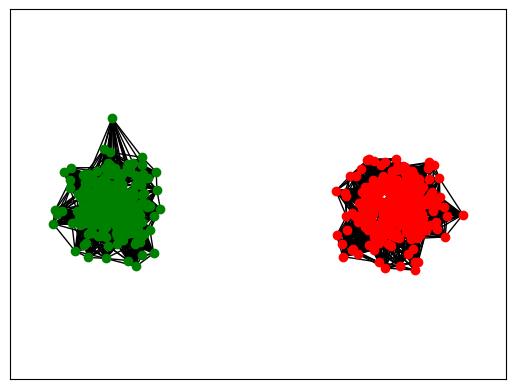

In [15]:
W = build_similarity_graph(X, k=int(np.sqrt(X.shape[0])))
plot_edges_and_points(X, Y, W)

As suggested in class, I have opted for a k-NN approach using k=sqrt(N) to build the similarity graph. One can clearly see in the plot above that the graph is no longer connected.

Since we now have two connected components, we know by a property seen in class that the first two eigenvectors are are associated to eigenvalues of value 0. Therefore, we no longer consider the second smallest eigenvector for spectral clustering, but rather the third smallest eigenvector.

In the case of two disconnected components, we know that the two eigenvectors associated to the eigenvalues 0 will have constant values for data points within the same component and different values for data points between components. In other words, it suffices to consider one of these two vectors to obtain a perfect clustering, without even having to apply k-means.

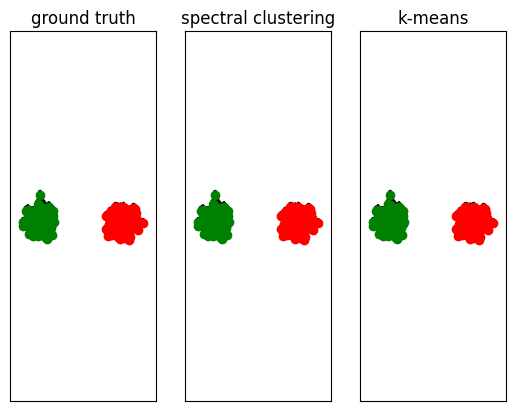

In [16]:
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[0], num_classes=2)

plot_clustering_result(X, Y, L, Y_rec, KMeans(2, random_state=42).fit_predict(X))

In [17]:
E, U = scipy.linalg.eigh(L)
U[:, 0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

### Q2.3: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

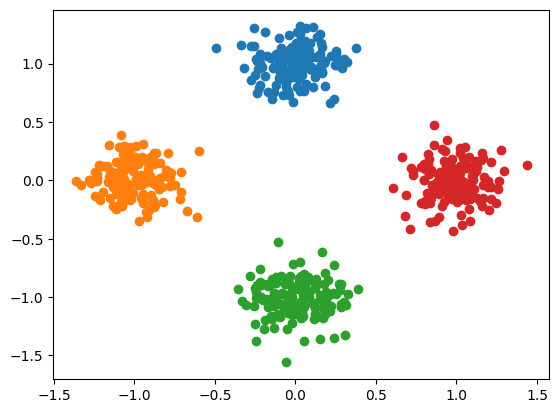

In [18]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.15)
plot_clusters(X, Y)

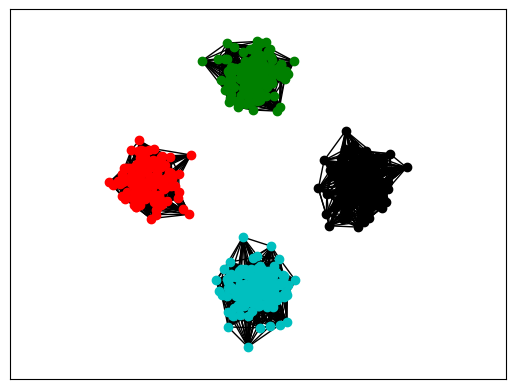

In [19]:
W = build_similarity_graph(X, k=int(np.sqrt(X.shape[0])))
plot_edges_and_points(X, Y, W)

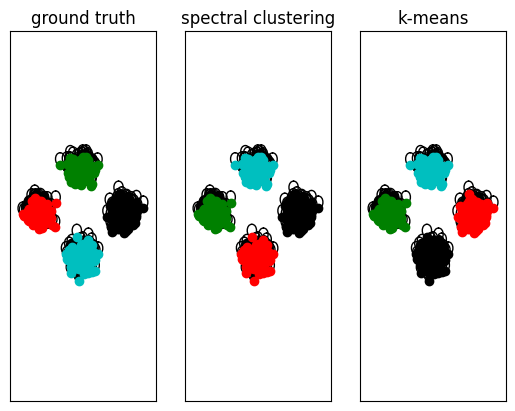

In [20]:
L = build_laplacian(W)
Y_rec = spectral_clustering(L, num_classes=4)

plot_clustering_result(X, Y, L, Y_rec, KMeans(4, random_state=42).fit_predict(X))

The idea desrcibed in the previous question can be generalized to the case when we have multiple classes, considering both connected graphs, as well disconnected graphs.

In the case where our similarity graph is connected, we know that only the first eigenvector has an associated eigenvalue of value 0. To cluster the data into k groups, we need to use the k-1 eigenvectors corresponding to the k-1 smallest non-zero eigenvalues. These eigenvectors provide information about the best ways to partition the data.

In the case where our similarity graph is disconnected, we will have k zero eigenvalues if we have k disconnected components. In this case, we only need k-1 of these eigenvectors corresponding to zero eigenvalues to completely determine the clustering. The corresponding eigenvectors will have constant values for data points within the same component but different values for data points between components. These eigenvectors provide perfect separation information, unlike in the connected case where the splits are approximations.

The intuition as to why it suffices to only consider k-1 vectors is due to the fact that if we manage to assign data points to one of k-1 clusters, then all remaining, unassigned data points should belong to the final k-th cluster.

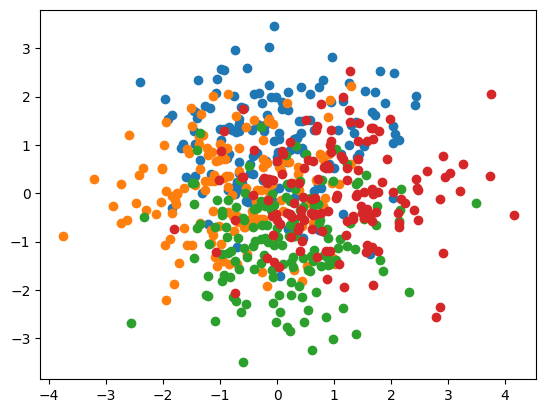

In [21]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=1)
plot_clusters(X, Y)

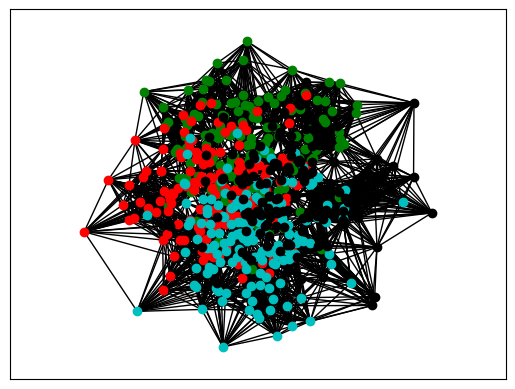

In [22]:
W = build_similarity_graph(X, k=int(np.sqrt(X.shape[0])))
plot_edges_and_points(X, Y, W)

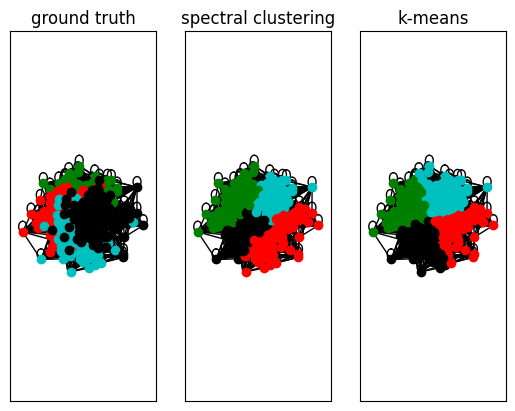

In [23]:
L = build_laplacian(W)
Y_rec = spectral_clustering(L, num_classes=4)

plot_clustering_result(X, Y, L, Y_rec, KMeans(4, random_state=42).fit_predict(X))

When increasing the variance of the blobs, they tend to become less easy to separate linearly. Nevertheless, spectral clustering performs relatively well compared to k-means, as can be seen in the plot above.

### Q2.4: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

Following what was suggested in the lecture notes, I decided to use k-means to implement the cluster assignment.

I would assume that thresholding works particularly well when the data naturally separates into clear components or when considering binary clustering (becomes more complex with multiple thresholds for multiple classes). On the other hand, k-means seems to more robust when dealing with connected graphs where the separation isn't perfect and tends to be better suited for multiple clusters as it naturally handles high-dimensional data well.

### Q2.5: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

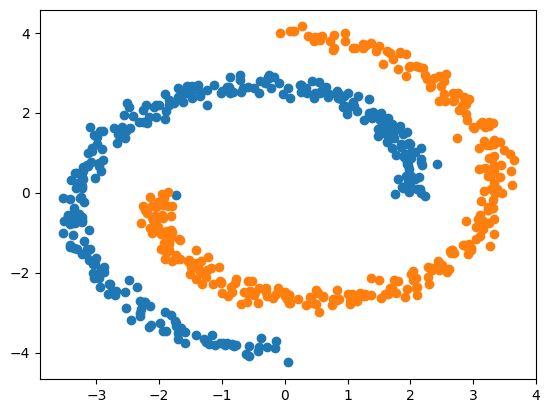

Signature: two_moons(num_samples, moon_radius=2.0, moon_var=0.02)
Docstring:
Creates two intertwined moons

:param num_samples: number of samples to create in the dataset
:param moon_radius: radius of the moons
:param moon_var:    variance of the moons
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment
File:      ~/Desktop/MVA/S2/Graphs in machine learning/Exercises/TP1/generate_data.py
Type:      function

In [24]:
two_moons?
X, Y = two_moons(num_samples=600)
plot_clusters(X, Y)

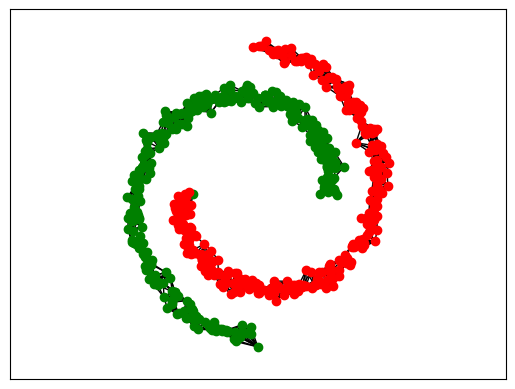

In [25]:
W = build_similarity_graph(X, k=10)
plot_edges_and_points(X, Y, W)

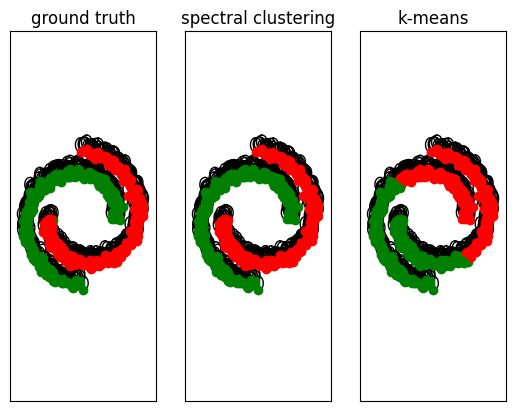

In [26]:
L = build_laplacian(W)
Y_rec = spectral_clustering(L, num_classes=2)

plot_clustering_result(X, Y, L, Y_rec, KMeans(2, random_state=42).fit_predict(X))

By using the k-NN approach with k=10, we get a very satisfying cluster separation for spectral clustering, while k-means struggles to distinguish the two classes.

On the one hand, spectral clustering correctly separates both moons by leveraging the graph structure and taking local neighborhood relationships into consideration. On the other hand, k-means fails because it only considers Euclidean distances between points and assumes linearly separable clusters. It creates a more linear division that doesn't respect the underlying curved structure of the moons.

### Q2.6: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

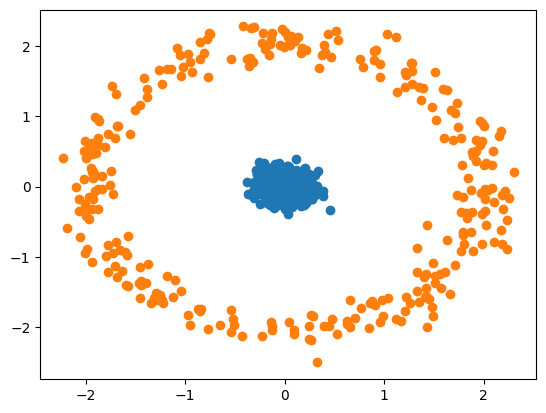

Signature: point_and_circle(num_samples, radius=2.0, sigma=0.15)
Docstring:
Creates point and circle

:param num_samples: number of samples to create in the dataset
:param sigma:       variance
:param radius:      radius of the circle
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment in {0, ..., c-1}
File:      ~/Desktop/MVA/S2/Graphs in machine learning/Exercises/TP1/generate_data.py
Type:      function

In [27]:
point_and_circle?
X, Y = point_and_circle(num_samples=600)
plot_clusters(X, Y)

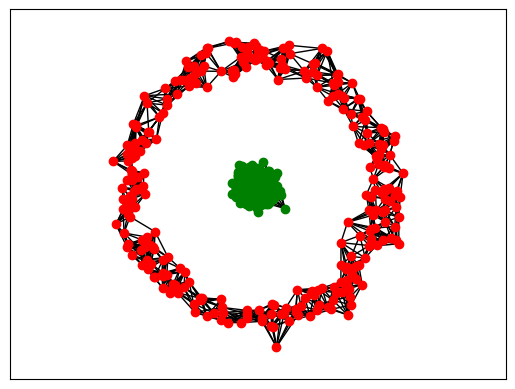

In [28]:
W = build_similarity_graph(X, k=10)
plot_edges_and_points(X, Y, W)

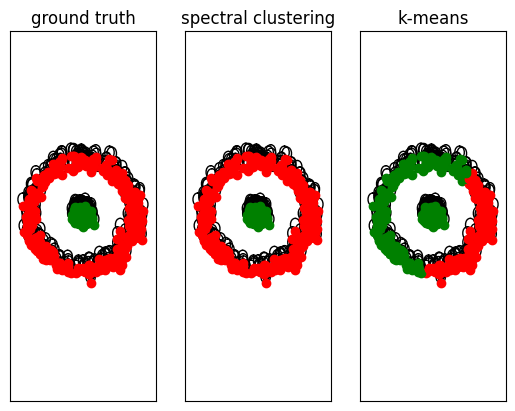

In [29]:
L = build_laplacian(W)
Y_rec = spectral_clustering(L, num_classes=2)

plot_clustering_result(X, Y, L, Y_rec, KMeans(2, random_state=42).fit_predict(X))

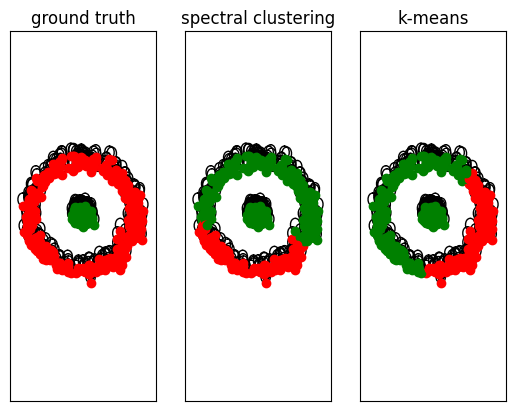

In [30]:
L = build_laplacian(W, laplacian_normalization='rw')
Y_rec = spectral_clustering(L, num_classes=2)

plot_clustering_result(X, Y, L, Y_rec, KMeans(2, random_state=42).fit_predict(X))

By using the k-NN approach with k=10 once again, one can notice that the the choice of Laplacian plays an important role in the final clustering. With the normal Laplacian (first plot), spectral clustering preserves the original grouping, correctly separating the inner circle from the outer ring. With the random walk Laplacian (second plot), the clustering boundary shifts, splitting the outer ring. My guess is that this occurs because the random walk Laplacian is less sensitive to density variations and normalizes edge weights by node degree.

### Q2.7: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

Testing variance sensitivity...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Testing k-NN sensitivity...
Testing epsilon sensitivity...
Testing Laplacian normalization sensitivity...


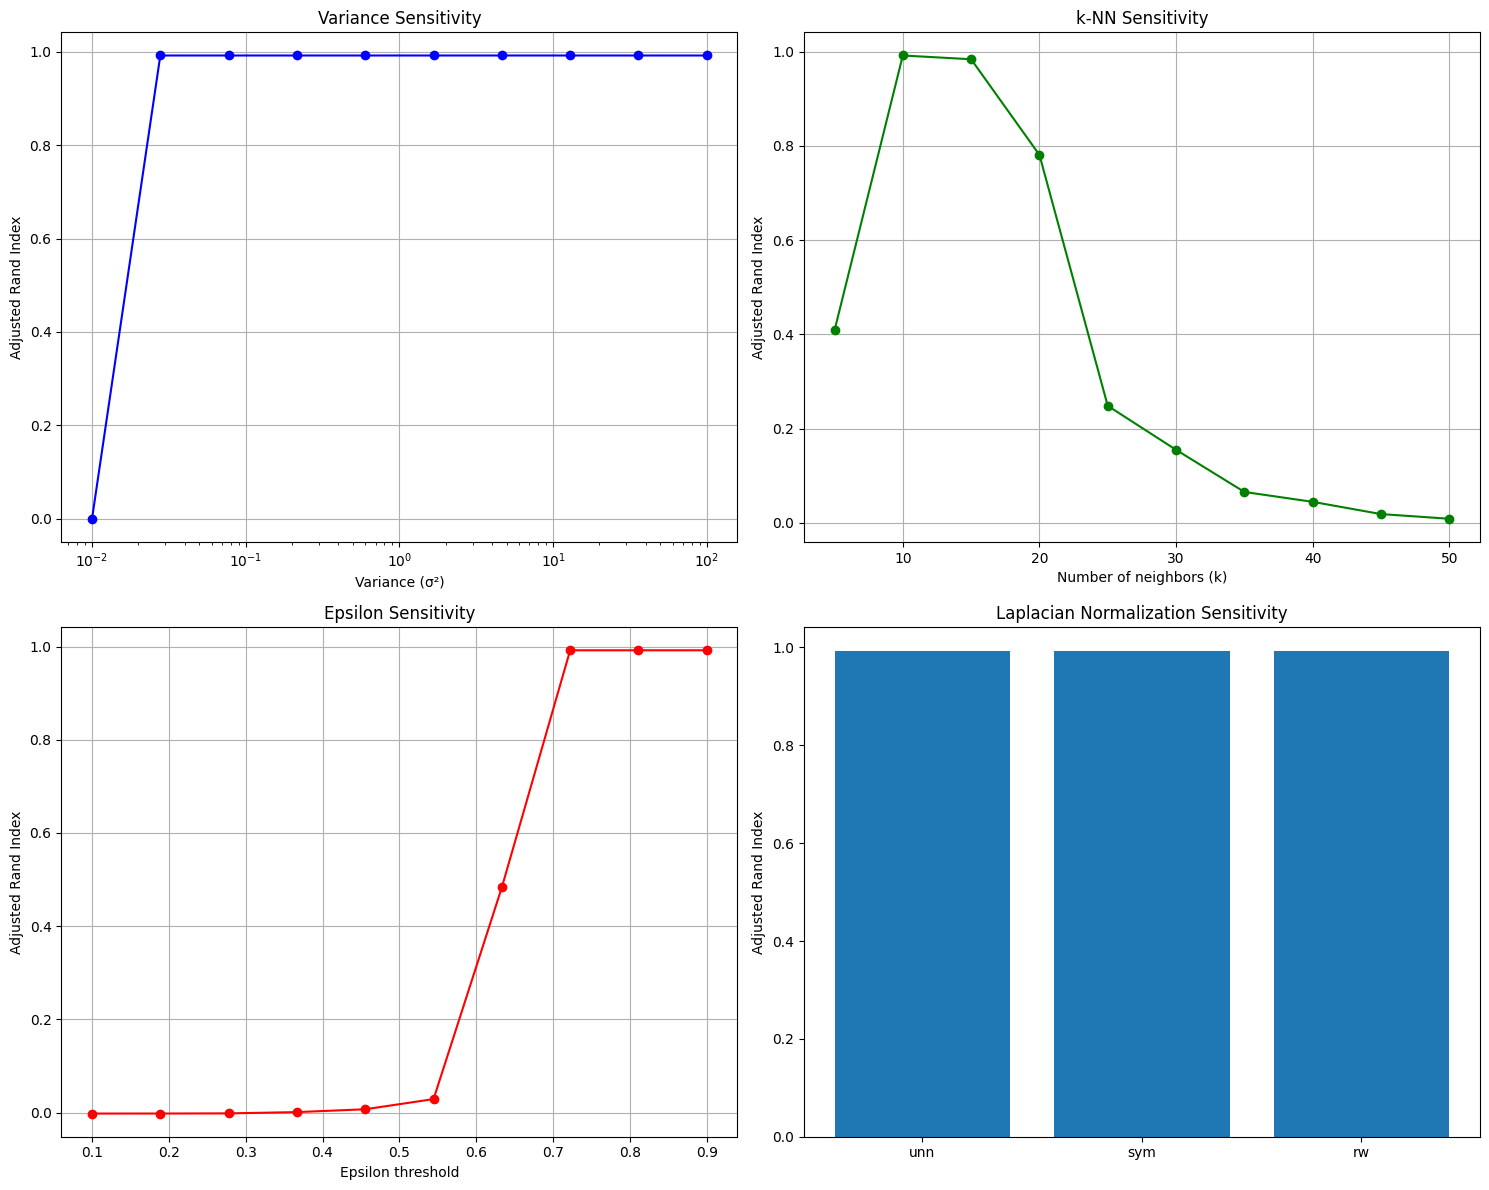

{'var': {'params': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
         5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
         3.59381366e+01, 1.00000000e+02]),
  'scores': [0.0,
   0.9919999681285151,
   0.9919999681285151,
   0.9919999681285151,
   0.9919999681285151,
   0.9919999681285151,
   0.9919999681285151,
   0.9919999681285151,
   0.9919999681285151,
   0.9919999681285151]},
 'k': {'params': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]),
  'scores': [0.4085705714862705,
   0.9919999681285151,
   0.984032001021952,
   0.7810211836698036,
   0.24851277764310656,
   0.1551383965308573,
   0.0657353636188779,
   0.044745369200914854,
   0.01876966922444398,
   0.008830508342903928]},
 'eps': {'params': array([0.1       , 0.18888889, 0.27777778, 0.36666667, 0.45555556,
         0.54444444, 0.63333333, 0.72222222, 0.81111111, 0.9       ]),
  'scores': [-0.001991456848197271,
   -0.0019430730881514642,
   -0.0016066859724335508,
   0.00

In [31]:
parameter_sensitivity()

Based on the plots above, one can notice that the choice of $\epsilon$ and k is crucial as far as clustering performance is concerned.

The k-NN sensitivity shows stable performance in terms of Adjusted Rand Index for a certain range of k (in this case 10-20), then drops quite rapidly. This suggests that choosing k too large disrupts the local neighborhood structure which is crucial for spectral clustering.

For the epsilon threshold one can observe the exact opposite trend, as the overall performance improves drastically from around ε=0.7. Below this value, the overall performance is poor (close to 0), while above 0.7, it achieves almost optimal performance (close to 1). This indicates the importance of choosing ε large enough to capture meaningful connections but small enough to maintain local structure.

### Q2.8: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

In the case where we have certain domain knowledge regarding the data points that we wish to classify, we could attempt to assign labels to the data points ourselves. However, this should be done with a lot of caution and is not feasible in most cases.

Instead of relying on supervised metrics such as the Adjusted Rand Index which require labeled data, one can use so-called internal metrics. One of many such examples is the intra-cluster sum of squares, which evaluates the compactness of the different clusters.

### Q3.1: Complete all the code necessary, and cluster the `four_elements` and `fruit_salad` images in the data folder and include here some images of the clustering.  Explain your design choices in the overall pipeline (e.g. which graph, which pre-processing...) and how you think they impact the results you are seeing. Report also at least one failure mode for the algorithm.

Building similarity graph...
Building Laplacian matrix...
Running spectral clustering...


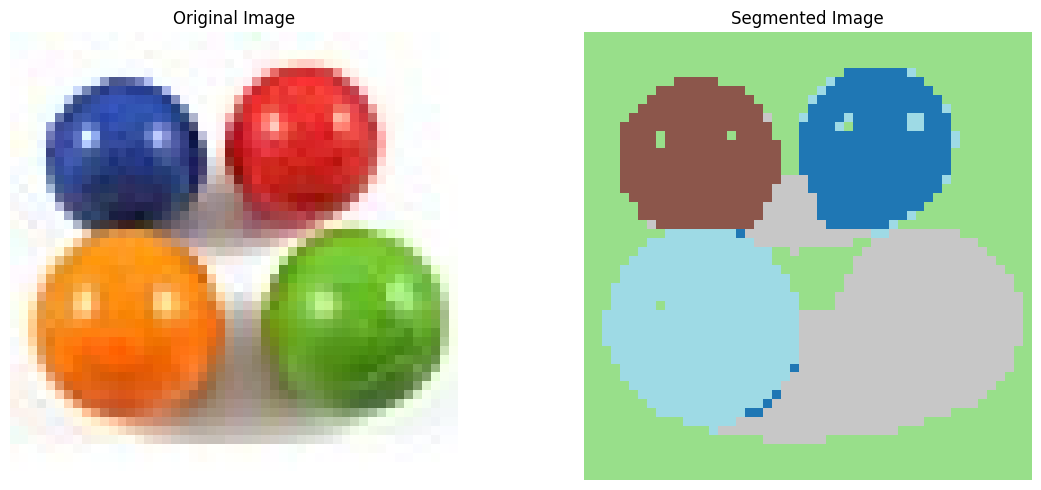

In [32]:
image_segmentation('four_elements.bmp')

Building similarity graph...
Building Laplacian matrix...
Running spectral clustering...


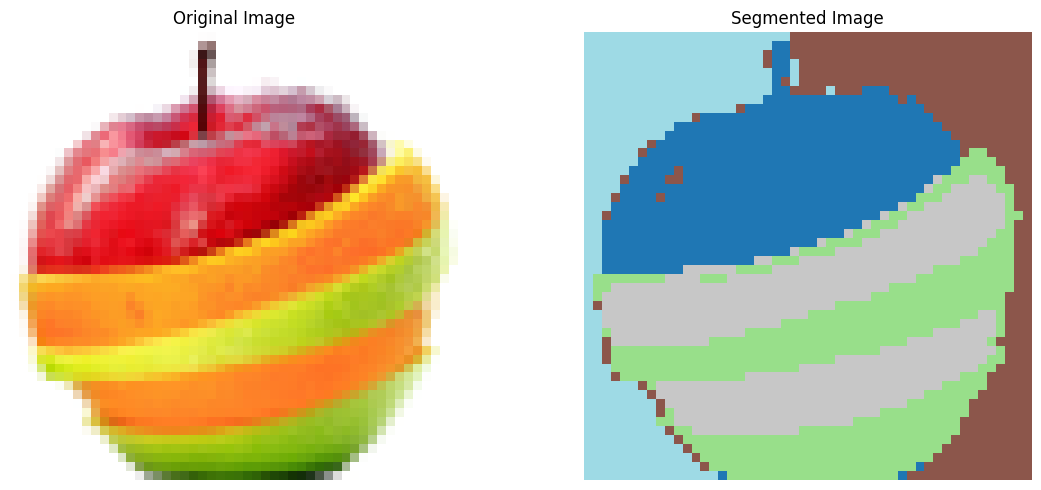

In [33]:
image_segmentation('fruit_salad.bmp')

As far as design choices are concerned, I decided to combine colour and spatial features with a chosen spatial weight of 0.1. This slightly modified approach allows to take the position of pixels into consideration, while keeping the main focus on the colour itself. The pipeline uses several key parameters including 30 nearest neighbours for the graph construction, a Gaussian kernel variance of 0.02, 5 target clusters (number of segments) and symmetric Laplacian normalization.

The results show effective segmentation in both test cases. For the four_elements image, the algorithm successfully separates the four coloured spheres into distinct clusters while maintaining clear boundaries. The fruit_salad image shows the algorithm's ability to distinguish the main segments of the sliced fruit, effectively distinguishing between different coloured regions.

A notable failure mode occurs when dealing with objects that have gradual color transitions, such as natural shading in the fruit image. The algorithm may struggle in these cases, either oversegmenting or undersegmenting the image. This can happen when the chosen number of clusters doesn't align with the number of natural segments in the image.

### Q3.2: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think of two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

A first possible technique would be to use a sparse k-nearest neighbors graph instead of a fully connected graph. Rather than computing and storing similarities between most pairs of pixels, one could only maintain connections between each pixel and its k nearest neighbors (as I have already implemented when choosing k=10 or k=30). This dramatically reduces both memory usage and computation time. For an n x n image, this can change the memory requirement from O(n^4) for a full graph to O(kn^2) for the sparse graph (k << n). The computational complexity for the eigenvalue decomposition similarly decreases from O(n^6) to O(kn^2).

A second possible technique would be to downsample the image before using spectral clustering, before upsampling the obtained segmentation result. For example, one could reduce a 1920 x 1080 image to 192 x 108 pixels (using e.g. averaging or a different interpolation method), perform the clustering on this smaller image and then scale the segmentation back up to its original size. While this leads to some loss in detail, it makes the problem much more feasible, since both memory and computation are reduced by a factor of 100 in each dimension. For the upsampling step, one can use nearest neighbor interpolation to maintain clear segment boundaries.

### Q3.3: Choose a larger image of your choice, and try to implement some of the scalability modifications to run spectral clustering on it. Report some examples of the results you achieve. 

In [41]:
def image_segmentation2(input_img='luxembourg_flag.png', downsample_factor=50):

    filename = os.path.join('data', input_img)
    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))
    
    original_height, original_width = X.shape[:2]
    
    new_height = original_height // downsample_factor
    new_width = original_width // downsample_factor
    
    X_downsampled = resize(X, (new_height, new_width), anti_aliasing=True, mode='reflect')
    
    y_coords, x_coords = np.mgrid[0:new_height, 0:new_width]
    
    x_coords = x_coords / new_width
    y_coords = y_coords / new_height
    
    spatial_weight = 0.1
    Xr = np.column_stack([
        X_downsampled.reshape(new_height * new_width, 3),
        spatial_weight * x_coords.reshape(new_height * new_width, 1),
        spatial_weight * y_coords.reshape(new_height * new_width, 1)
    ])
    
    var = 0.02
    k = 30
    laplacian_normalization = 'sym'
    num_classes = 4
    chosen_eig_indices = range(1, num_classes)
    
    print("Building similarity graph...")
    W = build_similarity_graph(Xr, var=var, k=k)
    
    print("Building Laplacian matrix...")
    L = build_laplacian(W, laplacian_normalization)
    
    print("Running spectral clustering...")
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)
    
    Y_rec = Y_rec.reshape(new_height, new_width)
    
    Y_rec_upsampled = resize(Y_rec, (original_height, original_width), order=0, preserve_range=True)
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(X)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(X_downsampled)
    plt.title(f'Downsampled Image (by factor {downsample_factor})')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(Y_rec_upsampled, cmap='tab20')
    plt.title('Segmented Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Building similarity graph...
Building Laplacian matrix...
Running spectral clustering...


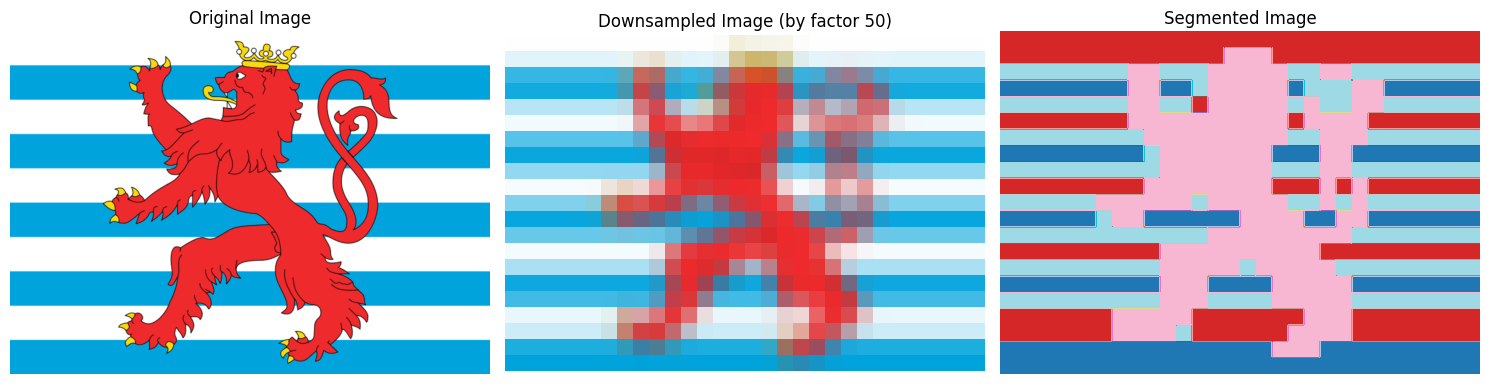

In [43]:
image_segmentation2()

Based on the obtained results, one can see that downsampling by a factor of 50 and averaging out the pixels seems to work fairly well in this case, while only taking a fraction of a second to run.